<a href="https://colab.research.google.com/github/AHromic1/Eco-friendly-Carpool-Optimization-Using-Clustering-and-Travel-Data/blob/main/New_progress_of_clustering.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

We wanted to understand whether clustering helps or limits carpool formation. To evaluate that, we want to compare a clustering-based pipeline (KMeans, AGNES) with a greedy no-cluster strategy that only uses route, time, and driver availability. This showed us the maximum possible number of people that can be included in carpooling, and how well clustering improves cost and CO₂ optimization.

# Greedy algorithm

In [ ]:
import pandas as pd
from datetime import timedelta

missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")

df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["car_model"] = df["car_model"].fillna("average_carpool")
df["has_car"] = df["has_car"].fillna(False)
df["car_capacity"] = df["car_capacity"].fillna(0)

carpool_groups = []
used = set()
group_id = 1

for (start_city, end_city), route_df in df.groupby(["start_city", "end_city"]):
    route_df = route_df.sort_values("start_date")

    for i in range(len(route_df)):
        if i in used:
            continue

        driver = route_df.iloc[i]
        if not driver["has_car"] or pd.isna(driver["car_capacity"]):
            continue

        carpool_group = [driver]
        used.add(driver.name)
        capacity_left = int(driver["car_capacity"]) - 1

        candidates = route_df[
            (~route_df.index.isin(used)) &
            (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
            (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
            (route_df["person_id"] != driver["person_id"])
        ]

        for _, passenger in candidates.iterrows():
            if capacity_left <= 0:
                break
            carpool_group.append(passenger)
            used.add(passenger.name)
            capacity_left -= 1

        if len(carpool_group) > 1:
            group_df = pd.DataFrame(carpool_group)
            group_df["carpool_group_id"] = f"group_{group_id}"
            carpool_groups.append(group_df)
            group_id += 1

if carpool_groups:
    final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
    final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
    final["days"] = final["days"].clip(lower=1)

    final["co2_total"] = final["co2_per_km"] * final["km"]
    final["hotel_total"] = final["hotel_cost"] * final["days"]
    final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

    stats = final.groupby("carpool_group_id").agg({
        "co2_total": "sum",
        "total_trip_cost": "sum",
        "person_id": "count"
    }).rename(columns={"person_id": "number_of_people"})

    print(stats.head(10))
    print(f"\nTotal groups: {len(stats)}")
    print(f"Total people assigned: {final['person_id'].nunique()}")
    print(f"Total CO₂: {stats['co2_total'].sum():.2f} kg")
    print(f"Total cost: {stats['total_trip_cost'].sum():.2f} €")

    stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/greedy_carpool_results.csv")
else:
    print("No carpool groups.")


                  co2_total  total_trip_cost  number_of_people
carpool_group_id                                              
group_1              80.620             1188                 3
group_10             49.755             3053                 3
group_11            121.325             2648                 3
group_12            245.870             4638                 4
group_13             52.320             6616                 5
group_14            142.445             2665                 3
group_15             74.700              677                 1
group_16            107.330             3551                 3
group_17             50.880             2003                 2
group_18            173.335             4005                 3

Total groups: 80
Total people assigned: 250
Total CO₂: 9898.94 kg
Total cost: 234401.00 €


We tested a greedy carpool group formation algorithm without any clustering. Unlike KMeans or AGNES-based methods that only assigned a subset of travelers (e.g. 6 to 11 groups with 2-4 people), the greedy strategy aimed to maximize group coverage across all users.

As a result, it managed to assign 250 people into 80 carpool groups. However, this comes at a higher total cost (€234,401) and CO₂ emissions (9898.94 kg) compared to optimized clustering-based approaches (which stayed under €10,000 and 1000 kg CO₂).

Thus, while greedy grouping ensures high coverage, it lacks in cost and environmental efficiency. It provides a useful benchmark but must be improved (e.g. via hybrid strategies) to become competitive.

# Kmeans with k=10

First it is necessary to import important libraries so we did that.

In [ ]:
pip install gower

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")

df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
#now we select only the most relevant features for clustering
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()


In [ ]:
df_selected.fillna(df_selected.mean(), inplace=True)

#OneHotEncode for 'is return trip' because it is categorical variable
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]), columns=encoder.get_feature_names_out(["is_return_trip"]))

#combining 'is return trip' column with the numerical features
df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1), encoded_df], axis=1)

scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])


Silhouette Score: 0.269


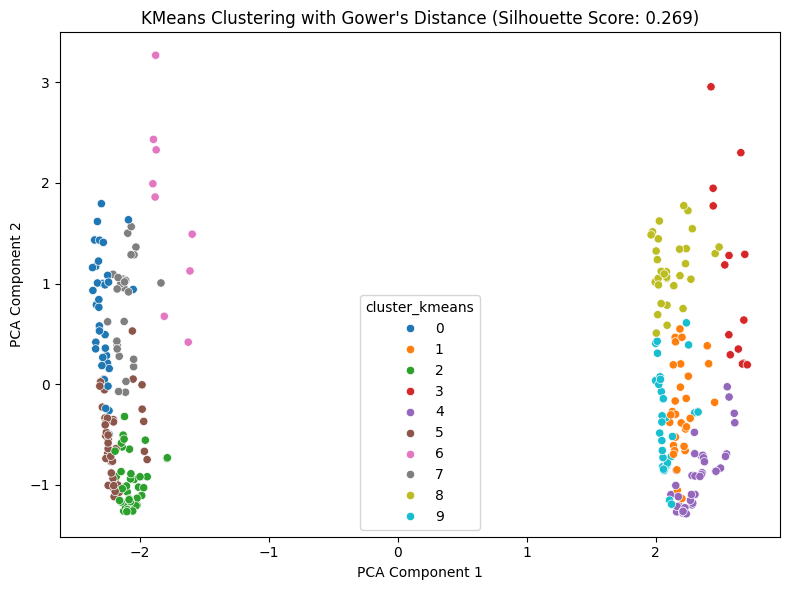

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features.csv", index=False)

We applied KMeans clustering on a Gower distance matrix using the most relevant carpooling-related features:

- km (travel distance),
- total_cost (trip cost),
- co2_per_km (CO₂ efficiency),
- is_return_trip (boolean).

To handle the mixed data types, we encoded the categorical variable (is_return_trip) using OneHotEncoder and applied StandardScaler to numerical features. The clustering was performed with KMeans (k=10) and evaluated using the Silhouette Score. Silhouette score indicates that clusters are somewhat separated, but not perfectly distinct.

We visualized the clusters using PCA to reduce the high-dimensional data to 2D. The PCA plot shows that:
- two dominant groups are clearly separated across PCA Component 1.
- some smaller clusters overlap, likely due to similar costs or emissions profiles.

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_kmeans
5    42
4    39
2    39
0    37
8    33
1    31
9    30
7    26
3    14
6     9
Name: count, dtype: int64


The KMeans clustering algorithm formed 10 distinct clusters. Cluster sizes range from 9 to 42 individuals. Most clusters are evenly populated, which indicates a well-balanced partitioning of the dataset. Smaller clusters may represent unique travel patterns or outliers.

So a cluster doesn't mean one carpool group , instead it's more like a pool of candidates who are traveling similarly (maybe on similar routes, durations, emissions) and can be considered for potential grouping together.

# Kmeans with k=30

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")

df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
#now we select only the most relevant features for clustering
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()


In [ ]:
df_selected.fillna(df_selected.mean(), inplace=True)

#OneHotEncode for 'is return trip' because it is categorical variable
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]), columns=encoder.get_feature_names_out(["is_return_trip"]))

#combining 'is return trip' column with the numerical features
df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1), encoded_df], axis=1)

scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])


Silhouette Score: 0.258


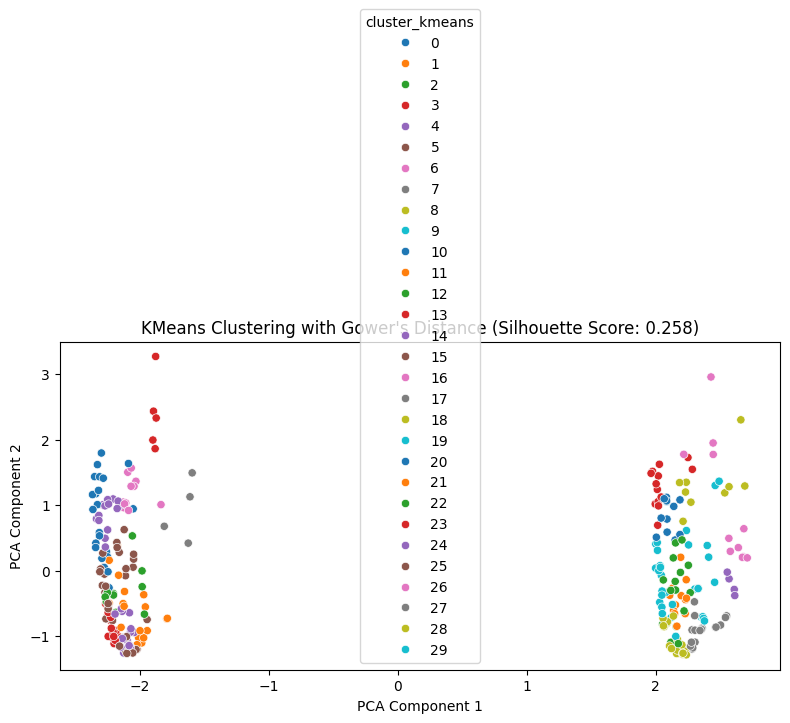

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features_30k.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_kmeans
8     20
3     16
29    16
15    15
14    15
23    15
25    15
24    13
1     12
0     12
10    12
17    12
20    11
26    11
22    10
12    10
21     9
9      9
11     9
5      8
16     7
2      6
27     6
19     5
18     5
13     5
4      4
28     4
6      4
7      4
Name: count, dtype: int64


Now, we applied KMeans clustering with k=30 on the dataset using the most relevant carpooling features as earlier .
The clustering was based on a Gower distance matrix that handles both numerical and categorical data. The result produced 30 distinct clusters, with sizes ranging from 4 to 20 individuals.

Most clusters are reasonably sized , which is ideal for forming smaller carpooling groups. Some clusters are very small, possibly capturing unique patterns (outliers or highly specific emission-cost profiles).

This granularity could help us match more compatible carpooling candidates and reduce CO₂ emissions more precisely during optimization.

We will do in the next step clustering with k=50 and then we will create groups based on these three types with k=10, k=30 and k=50 to see which gives the best result.

# Kmeans with k=50

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")

df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)

In [ ]:
#now we select only the most relevant features for clustering
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()


In [ ]:
df_selected.fillna(df_selected.mean(), inplace=True)

#OneHotEncode for 'is return trip' because it is categorical variable
encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]), columns=encoder.get_feature_names_out(["is_return_trip"]))

#combining 'is return trip' column with the numerical features
df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1), encoded_df], axis=1)

scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])


Silhouette Score: 0.281


<ipython-input-26-d079975dd806>:24: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


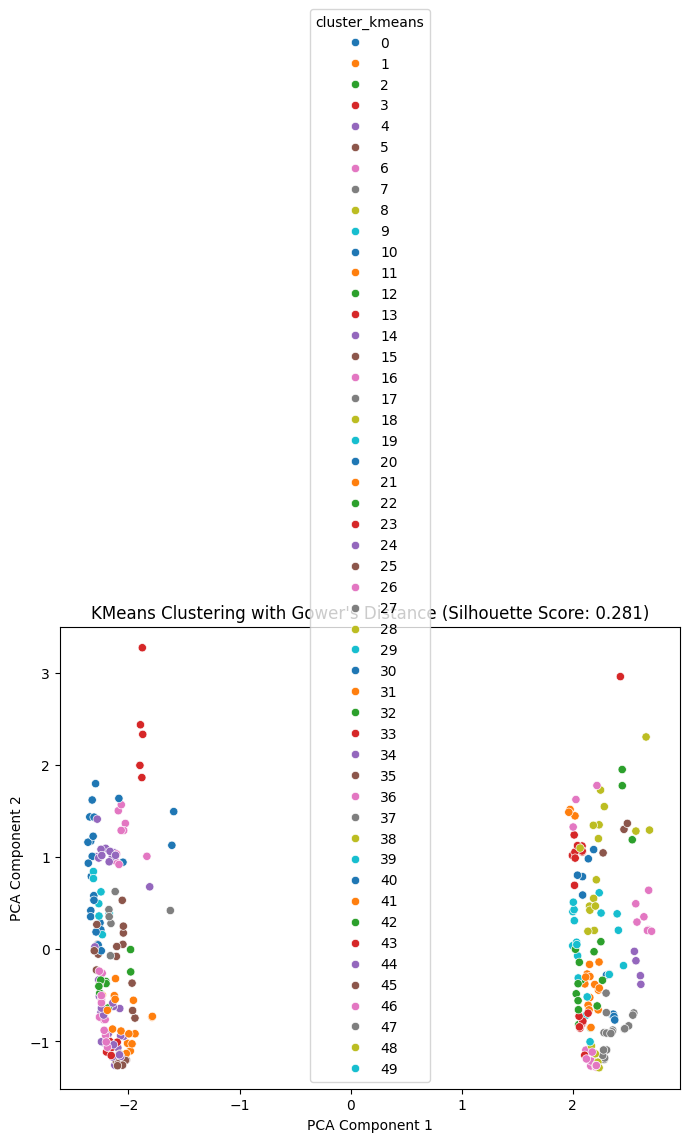

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=50, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features_50k.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 50
Cluster sizes:
 cluster_kmeans
36    13
0     12
14    11
23    11
24    11
15    10
20    10
41    10
26     9
46     9
34     9
21     9
33     8
22     8
3      8
39     8
37     7
49     7
11     7
38     7
16     7
42     7
17     6
8      6
30     5
10     5
47     5
45     5
25     5
13     5
27     5
5      4
9      4
4      4
29     4
18     4
1      4
12     4
19     3
32     3
35     3
31     3
28     3
6      3
2      2
48     2
40     2
44     1
43     1
7      1
Name: count, dtype: int64


In the end of clustering with Kmeans, we performed KMeans clustering with k=50 using the four core features relevant to carpooling based on a Gower distance matrix.

The result produced 50 clusters, with sizes ranging from 1 to 13 individuals:
- Most clusters are small, between 3-7 members.
- A few clusters have 10 or more members, which are more promising for forming carpool groups.
- However, over 10 clusters have only 1-2 members, which indicates possible over-segmentation or noise.

This clustering may offer very fine-grained grouping, but the large number of tiny clusters might limit practical carpool formation. We'll compare it with other `k` values in the optimization phase to evaluate trade-offs between precision and usability.


# Grouping and comparing various types of k

In [ ]:
import pandas as pd
from datetime import timedelta

In [ ]:
def evaluate_clustering(csv_path, cluster_col="cluster_kmeans"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  #€ for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                #finding of travelers for ±1 day
                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=1)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=1)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Kmeans variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}")
    else:
        print("No carpool groups.")


In [ ]:
#k=10
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features.csv", cluster_col="cluster_kmeans")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features.csv
Number of groups: 24
Total cost: €19557
Total CO2 emission: 1982.96 kg
CO2 tax: €88.44
Total number of unique people in carpool groups: 51


In [ ]:
#k=30
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features_30k.csv", cluster_col="cluster_kmeans")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features_30k.csv
Number of groups: 7
Total cost: €5661
Total CO2 emission: 635.68 kg
CO2 tax: €28.35
Total number of unique people in carpool groups: 14


In [ ]:
#k=50
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features_50k.csv", cluster_col="cluster_kmeans")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features_50k.csv
Number of groups: 6
Total cost: €4795
Total CO2 emission: 382.82 kg
CO2 tax: €17.07
Total number of unique people in carpool groups: 12


- With **k=10**, the clustering yields **24 carpool groups**, but with a total cost of **€19,557** and **CO₂ emissions of 1982.96 kg**.
- When using **k=30**, cost drops significantly to **€5661**, and emissions fall to **635.68 kg**.
- Finally, **k=50** delivers the most eco-efficient outcome, with only **€4795 total cost** and **just 382.82 kg of CO₂**, with fewer groups (6).

To conclude, by switching from a 10-cluster solution to a 50-cluster one, we cut **emissions by over 80%** and **costs by ~75%**.”



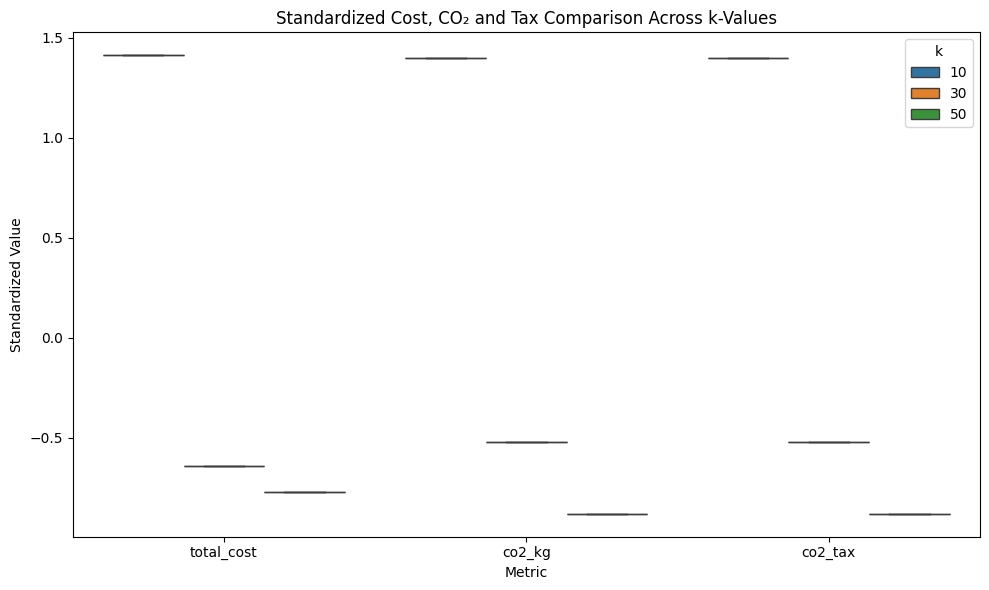

In [ ]:
summary_df = pd.DataFrame({
    "k": [10, 30, 50],
    "groups": [24, 7, 6],
    "total_cost": [19557, 5661, 4795],
    "co2_kg": [1982.96, 635.68, 382.82],
    "co2_tax": [88.44, 28.35, 17.07]
})

metrics_to_plot = ["total_cost", "co2_kg", "co2_tax"]
scaler = StandardScaler()
standardized = scaler.fit_transform(summary_df[metrics_to_plot])
standardized_df = pd.DataFrame(standardized, columns=metrics_to_plot)
standardized_df["k"] = summary_df["k"]

melted = pd.melt(standardized_df, id_vars="k", var_name="Metric", value_name="Standardized Value")

plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x="Metric", y="Standardized Value", hue="k", palette="tab10")
plt.title("Standardized Cost, CO₂ and Tax Comparison Across k-Values")
plt.legend(title="k")
plt.tight_layout()
plt.show()

This boxplot summarizes the standardized values for total cost, CO₂ emissions, and CO₂ tax across k=10, k=30, and k=50 clusters.

We chose to standardize the values so that all metrics could be directly compared.

Key insights:
- **k=10** has the highest emissions and cost across all three metrics.
- **k=50** consistently performs the best, with the lowest standardized CO₂ and tax.
- **k=30** is in between, offering a trade-off between group count and efficiency.


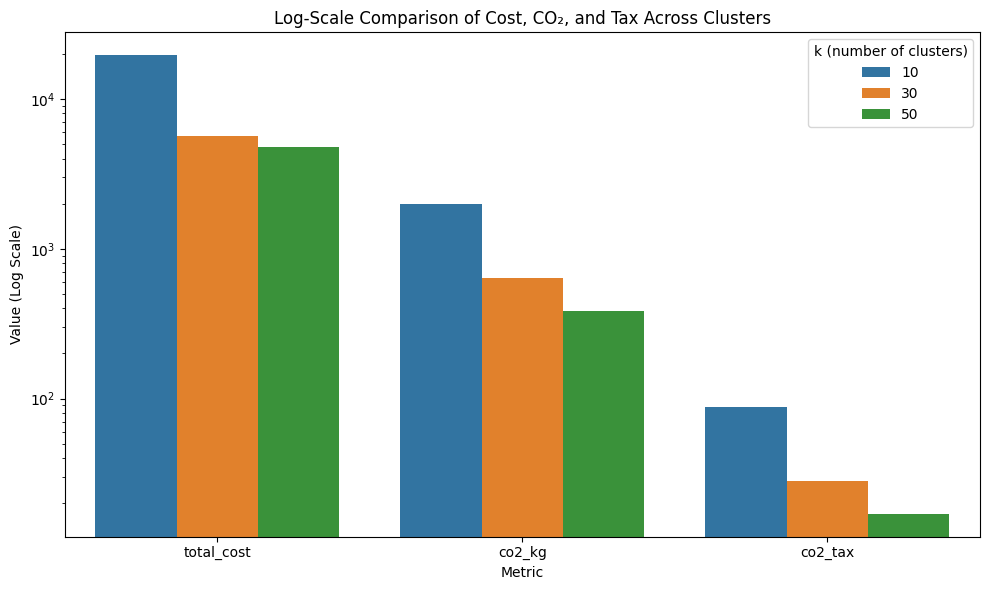

In [ ]:

summary_df = pd.DataFrame({
    "k": [10, 30, 50],
    "total_cost": [19557, 5661, 4795],
    "co2_kg": [1982.96, 635.68, 382.82],
    "co2_tax": [88.44, 28.35, 17.07]
})

df_long = pd.melt(summary_df, id_vars="k",
                  value_vars=["total_cost", "co2_kg", "co2_tax"],
                  var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

This bar chart uses a logarithmic scale to visually compare the impact of different KMeans cluster sizes on three key metrics:

- **Total Cost (€)**
- **Total CO₂ Emissions (kg)**
- **CO₂ Tax (€)**

Using a log scale helps to see relative differences between the values, even when some are an order of magnitude larger than others. It clearly shows that as the number of clusters increases, both **cost** and **CO₂ emissions** decrease significantly, making higher-k solutions more eco- and budget-friendly.

If we cluster smarter (k=50), we spend less and pollute less.

# Optimization of algorithm based on results of k=50 clustering

In [ ]:
from datetime import timedelta

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/with_Gower_KMeans_4features_50k.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_kmeans"].unique():
    cluster_df = df[df["cluster_kmeans"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups1.csv", index=True)
print(group_stats.head(10))


4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
4.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                        27.175                 2444   
group_2                       188.550                 1570   
group_3                       159.870                 1394   
group_4                         3.240                 2007   
group_5                        17.040                  721   
group_6                         7.092                 1018   
group_7                         7.476                 2993   
group_8                         4.116                 3439   

                 travel_mode_optimized  number_of_people  
carpool_group_id                                          
group_1                            car                 2  
group_2                            car                 2  
group_3                        

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups1.csv")  # replace with actual path

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 27.18 kg
Total cost: 2444.00 €

1
Number of people in group: 2
Optimized transport type: car
Total CO₂: 188.55 kg
Total cost: 1570.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 159.87 kg
Total cost: 1394.00 €

3
Number of people in group: 2
Optimized transport type: train
Total CO₂: 3.24 kg
Total cost: 2007.00 €

4
Number of people in group: 2
Optimized transport type: train
Total CO₂: 17.04 kg
Total cost: 721.00 €

5
Number of people in group: 2
Optimized transport type: train
Total CO₂: 7.09 kg
Total cost: 1018.00 €

6
Number of people in group: 2
Optimized transport type: train
Total CO₂: 7.48 kg
Total cost: 2993.00 €

7
Number of people in group: 2
Optimized transport type: train
Total CO₂: 4.12 kg
Total cost: 3439.00 €

==== TOTALS ====
Total cost for all groups: 15586.00 €
Total CO₂ emissions for all groups: 414.56 kg


After applying clustering with k = 50, we proceeded to form carpool groups based on car availability, capacity, and temporal proximity (±2 days). From these clusters, 8 carpool groups were formed. Then, we optimized travel modes by switching from car to train in cases where the train was at least 2 hours faster than the car. This significantly reduced CO₂ emissions.

The final output includes:

A clear balance between cost and CO₂ emission

Most groups switched to train, showing that train travel is not only environmentally beneficial but also a feasible optimization

Each group has exactly 2 members, meaning the car capacity constraint was respected and no group exceeds vehicle limits.

# Agnes with n=10

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import gower

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()
df_selected.fillna(df_selected.mean(numeric_only=True), inplace=True)

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]),
                          columns=encoder.get_feature_names_out(["is_return_trip"]))

df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1).reset_index(drop=True), encoded_df], axis=1)

scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.423


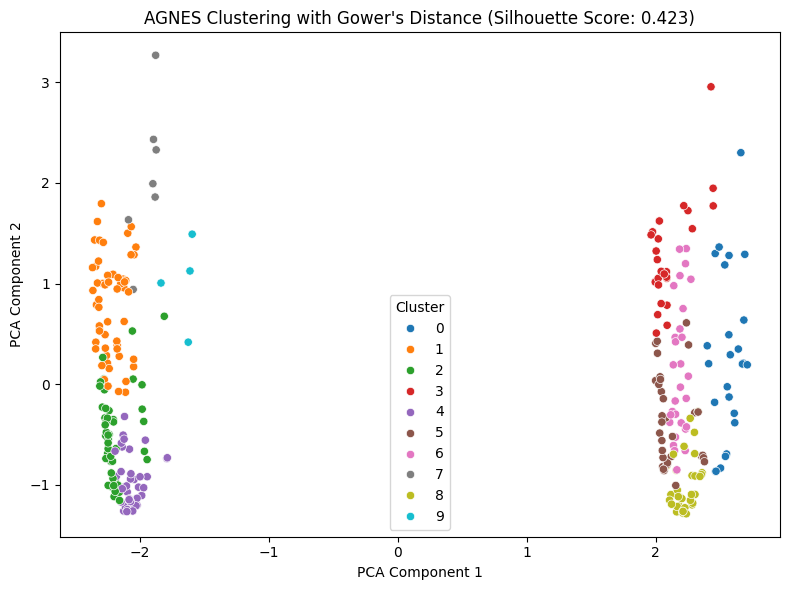

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=10, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k10.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 10
Cluster sizes:
 cluster_agnes
1    56
2    48
4    38
8    34
5    32
6    29
3    27
0    25
7     7
9     4
Name: count, dtype: int64


# Agnes with n=30

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import gower

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()
df_selected.fillna(df_selected.mean(numeric_only=True), inplace=True)

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]),
                          columns=encoder.get_feature_names_out(["is_return_trip"]))

df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1).reset_index(drop=True), encoded_df], axis=1)

scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.416


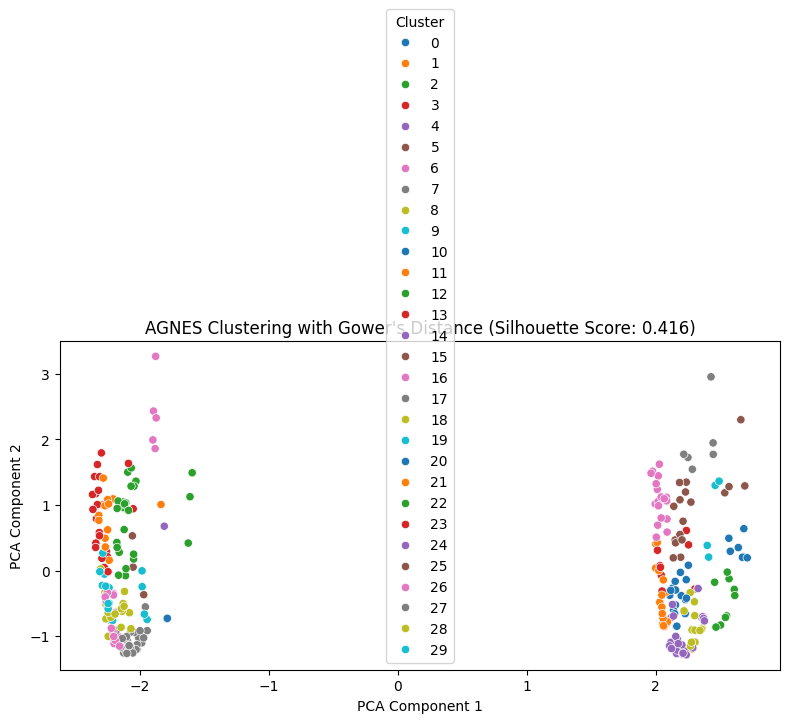

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=30, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k30.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 30
Cluster sizes:
 cluster_agnes
7     27
2     23
6     21
13    20
4     20
16    18
0     16
1     16
18    14
15    13
9     13
11    13
12    10
8      9
28     9
14     8
3      8
10     7
26     5
25     4
19     4
29     4
17     3
5      3
27     3
22     3
20     2
23     2
21     1
24     1
Name: count, dtype: int64


# Agnes with n=50

In [ ]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.decomposition import PCA
from sklearn.metrics import pairwise_distances, silhouette_score
from sklearn.cluster import AgglomerativeClustering
import matplotlib.pyplot as plt
import seaborn as sns
import gower

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()
df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
features = ["km", "total_cost", "co2_per_km", "is_return_trip"]
df_selected = df[features].copy()
df_selected.fillna(df_selected.mean(numeric_only=True), inplace=True)

encoder = OneHotEncoder(drop='first', sparse_output=False)
encoded_df = pd.DataFrame(encoder.fit_transform(df_selected[["is_return_trip"]]),
                          columns=encoder.get_feature_names_out(["is_return_trip"]))

df_encoded = pd.concat([df_selected.drop("is_return_trip", axis=1).reset_index(drop=True), encoded_df], axis=1)

scaler = StandardScaler()
df_encoded[["km", "total_cost", "co2_per_km"]] = scaler.fit_transform(df_encoded[["km", "total_cost", "co2_per_km"]])


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.477


<ipython-input-51-5fd8a9100f4c>:21: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all Axes decorations.
  plt.tight_layout()


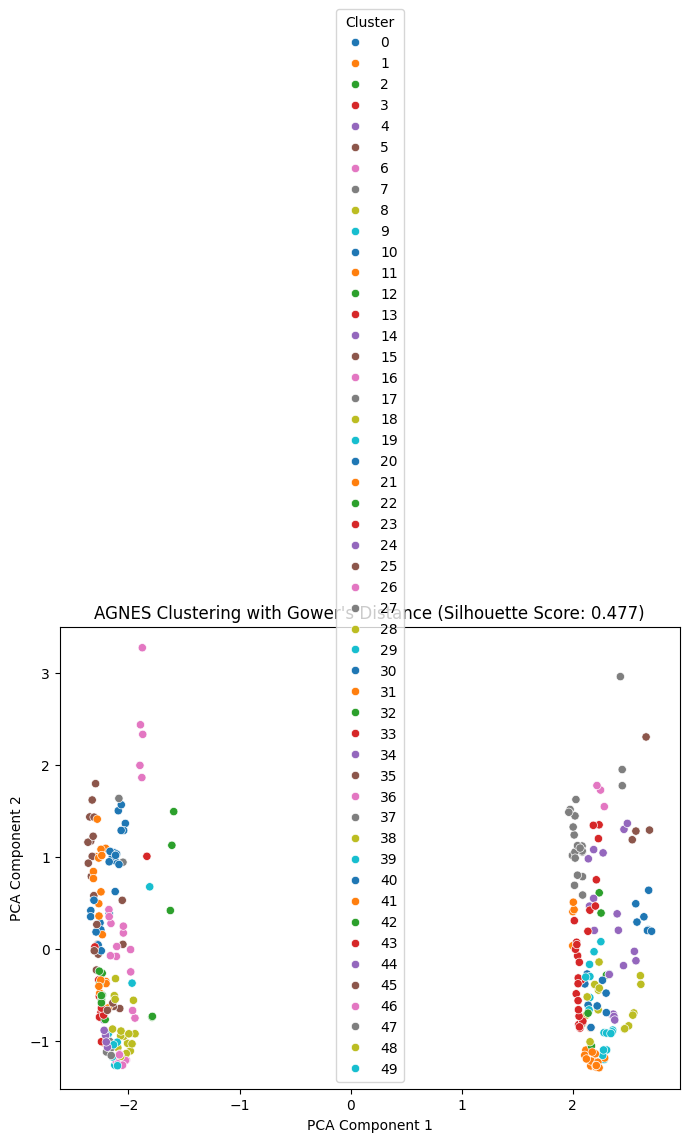

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=50, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k50.csv", index=False)

In [ ]:
print("Number of unique clusters:", df["cluster_agnes"].nunique())
print("Cluster sizes:\n", df["cluster_agnes"].value_counts())


Number of unique clusters: 50
Cluster sizes:
 cluster_agnes
1     17
0     15
7     14
11    13
3     13
15    11
8     11
46    10
9      9
13     9
40     9
16     8
12     8
10     7
23     7
18     7
37     7
29     7
19     6
17     6
21     6
34     6
48     5
26     5
20     5
14     5
28     5
24     5
45     5
33     5
4      4
35     4
5      4
6      4
30     4
38     3
2      3
31     3
36     3
44     3
32     3
22     3
27     3
25     2
47     2
42     2
49     1
43     1
39     1
41     1
Name: count, dtype: int64


# Grouping and comparing

In [ ]:
import pandas as pd
from datetime import timedelta

In [ ]:
def evaluate_clustering(csv_path, cluster_col="cluster_agnes"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  #€ for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                #finding of travelers for ±1 day
                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=1)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=1)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Kmeans variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}")
    else:
        print("No carpool groups.")


In [ ]:
from datetime import timedelta
import pandas as pd

def evaluate_clustering(csv_path, cluster_col="cluster_agnes"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])
    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  # € per kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=1)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=1)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate
        total_people = carpool_df["person_id"].nunique()

        print(f"Kmeans variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}")
        print(f"Total number of unique people in carpool groups: {total_people}")
    else:
        print("No carpool groups.")


In [ ]:
#k=10
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k10.csv", cluster_col="cluster_agnes")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k10.csv
Number of groups: 27
Total cost: €21777
Total CO2 emission: 2429.2 kg
CO2 tax: €108.34
Total number of unique people in carpool groups: 57


In [ ]:
#k=30
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k30.csv", cluster_col="cluster_agnes")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k30.csv
Number of groups: 11
Total cost: €8974
Total CO2 emission: 824.38 kg
CO2 tax: €36.77
Total number of unique people in carpool groups: 22


In [ ]:
#k=50
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k50.csv", cluster_col="cluster_agnes")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k50.csv
Number of groups: 4
Total cost: €3321
Total CO2 emission: 296.0 kg
CO2 tax: €13.2
Total number of unique people in carpool groups: 8


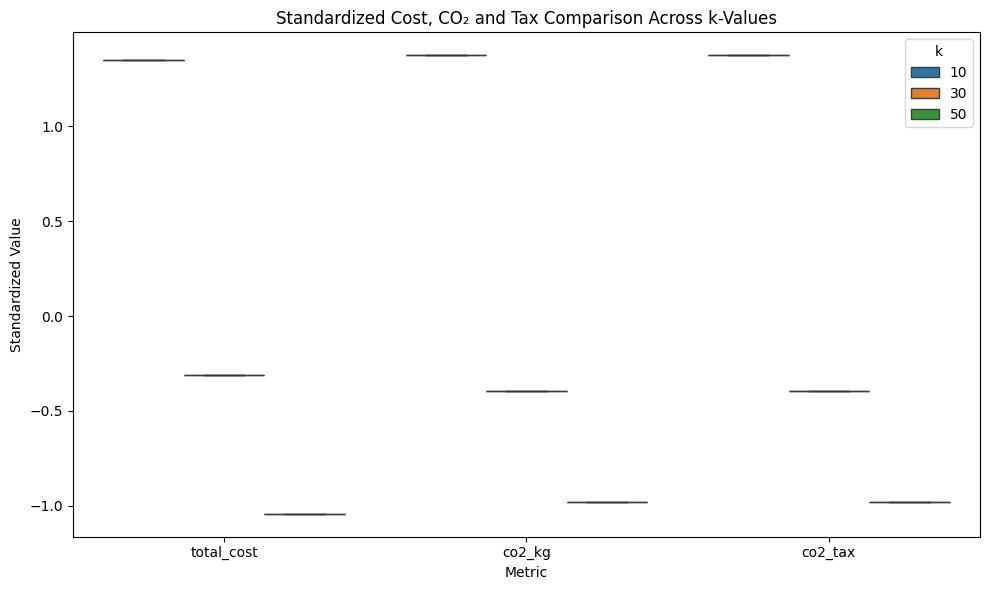

In [ ]:
summary_df = pd.DataFrame({
    "k": [10, 30, 50],
    "groups": [27, 11, 4],
    "total_cost": [21777, 8974, 3321],
    "co2_kg": [2429.2, 824.38, 296.0],
    "co2_tax": [108.34, 36.77, 13.02]
})

metrics_to_plot = ["total_cost", "co2_kg", "co2_tax"]
scaler = StandardScaler()
standardized = scaler.fit_transform(summary_df[metrics_to_plot])
standardized_df = pd.DataFrame(standardized, columns=metrics_to_plot)
standardized_df["k"] = summary_df["k"]

melted = pd.melt(standardized_df, id_vars="k", var_name="Metric", value_name="Standardized Value")

plt.figure(figsize=(10, 6))
sns.boxplot(data=melted, x="Metric", y="Standardized Value", hue="k", palette="tab10")
plt.title("Standardized Cost, CO₂ and Tax Comparison Across k-Values")
plt.legend(title="k")
plt.tight_layout()
plt.show()

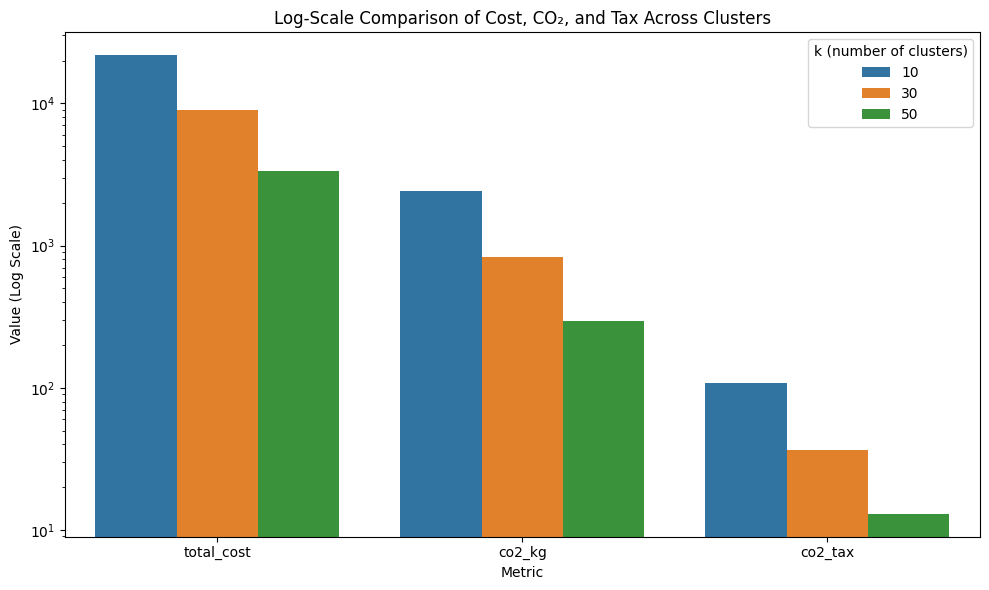

In [ ]:
summary_df = pd.DataFrame({
    "k": [10, 30, 50],
    "groups": [27, 11, 4],
    "total_cost": [21777, 8974, 3321],
    "co2_kg": [2429.2, 824.38, 296.0],
    "co2_tax": [108.34, 36.77, 13.02]
})


df_long = pd.melt(summary_df, id_vars="k",
                  value_vars=["total_cost", "co2_kg", "co2_tax"],
                  var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x="Metric", y="Value", hue="k", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Cost, CO₂, and Tax Across Clusters")
plt.tight_layout()
plt.legend(title="k (number of clusters)")
plt.show()

We used AGNES clustering with Gower's distance to group missions into potential carpool clusters and compared results using key metrics: total cost, CO₂ emissions, and CO₂ tax.

The summary is:

k=10 - High cost (€21,777) and CO₂ emissions (2,429.2 kg)

k=30 - Moderate cost (€8,974) and emissions (824.38 kg)

k=50 - Lowest cost (€3,321) and emissions (296.0 kg)

AGNES with k=50 gives the most efficient clustering with the lowest environmental and financial impact, making it the best choice for carpool group optimization but we will try optimization with k=30 also because we think that there is bad utilization of car capacity.


# Optimization of algorithm with n=50

In [ ]:
from datetime import timedelta

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k50.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_agnes"].unique():
    cluster_df = df[df["cluster_agnes"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups1agnes.csv", index=True)
print(group_stats.head(10))


4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                       194.845                 1239   
group_2                        17.040                  721   
group_3                       250.490                  881   
group_4                        31.600                 2325   
group_5                         7.092                 1018   
group_6                         4.116                 3439   
group_7                        78.700                 2524   

                 travel_mode_optimized  number_of_people  
carpool_group_id                                          
group_1                            car                 2  
group_2                          train                 2  
group_3                            car                 2  
group_4   

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups1agnes.csv")  # replace with actual path

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 194.84 kg
Total cost: 1239.00 €

1
Number of people in group: 2
Optimized transport type: train
Total CO₂: 17.04 kg
Total cost: 721.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 250.49 kg
Total cost: 881.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 31.60 kg
Total cost: 2325.00 €

4
Number of people in group: 2
Optimized transport type: train
Total CO₂: 7.09 kg
Total cost: 1018.00 €

5
Number of people in group: 2
Optimized transport type: train
Total CO₂: 4.12 kg
Total cost: 3439.00 €

6
Number of people in group: 2
Optimized transport type: car
Total CO₂: 78.70 kg
Total cost: 2524.00 €

==== TOTALS ====
Total cost for all groups: 12147.00 €
Total CO₂ emissions for all groups: 583.88 kg


# Optimization algorithm with n=30

In [ ]:
from datetime import timedelta

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k30.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_agnes"].unique():
    cluster_df = df[df["cluster_agnes"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups2agnes.csv", index=True)
print(group_stats.head(10))


5.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                       102.270                 2807   
group_10                       59.330                 2979   
group_11                       78.700                 2524   
group_12                       31.600                 2325   
group_13                       89.375                 2574   
group_14                       17.244                 2993   
group_15                        7.092                 1018   
group_16                      105.655                 1320   
group_2                       194.845                 1239   
group_3                       172.760                 1172   

                 travel

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups2agnes.csv")  # replace with actual path

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 102.27 kg
Total cost: 2807.00 €

1
Number of people in group: 2
Optimized transport type: car
Total CO₂: 59.33 kg
Total cost: 2979.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 78.70 kg
Total cost: 2524.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 31.60 kg
Total cost: 2325.00 €

4
Number of people in group: 2
Optimized transport type: car
Total CO₂: 89.38 kg
Total cost: 2574.00 €

5
Number of people in group: 2
Optimized transport type: train
Total CO₂: 17.24 kg
Total cost: 2993.00 €

6
Number of people in group: 2
Optimized transport type: train
Total CO₂: 7.09 kg
Total cost: 1018.00 €

7
Number of people in group: 2
Optimized transport type: car
Total CO₂: 105.66 kg
Total cost: 1320.00 €

8
Number of people in group: 2
Optimized transport type: car
Total CO₂: 194.84 kg
Total cost: 1239.00 €

9
Number of people in group: 2
Optimized transport type: c

# Optimization of algorithm with n=10

In [ ]:
from datetime import timedelta

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/AGNES_Gower_4features_k10.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_agnes"].unique():
    cluster_df = df[df["cluster_agnes"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups3agnes.csv", index=True)
print(group_stats.head(10))


5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
4.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                         7.128                 2546   
group_10                      233.960                 1705   
group_11                      188.550                 1570   
group_12                      250.490                  881   
group_13                       15.180                 2085   
group_14                       15.660                 2432   
group_15                       44.090   

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedgroups3agnes.csv")  # replace with actual path

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: train
Total CO₂: 7.13 kg
Total cost: 2546.00 €

1
Number of people in group: 2
Optimized transport type: car
Total CO₂: 233.96 kg
Total cost: 1705.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 188.55 kg
Total cost: 1570.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 250.49 kg
Total cost: 881.00 €

4
Number of people in group: 2
Optimized transport type: train
Total CO₂: 15.18 kg
Total cost: 2085.00 €

5
Number of people in group: 2
Optimized transport type: train
Total CO₂: 15.66 kg
Total cost: 2432.00 €

6
Number of people in group: 2
Optimized transport type: car
Total CO₂: 44.09 kg
Total cost: 2419.00 €

7
Number of people in group: 2
Optimized transport type: train
Total CO₂: 9.55 kg
Total cost: 2427.00 €

8
Number of people in group: 3
Optimized transport type: car
Total CO₂: 82.54 kg
Total cost: 3822.00 €

9
Number of people in group: 2
Optimized transport type:

Different features for clustering because the first one used are not good for grouping people

# Kmeans with k=10, changed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]

df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


Silhouette Score: 0.176


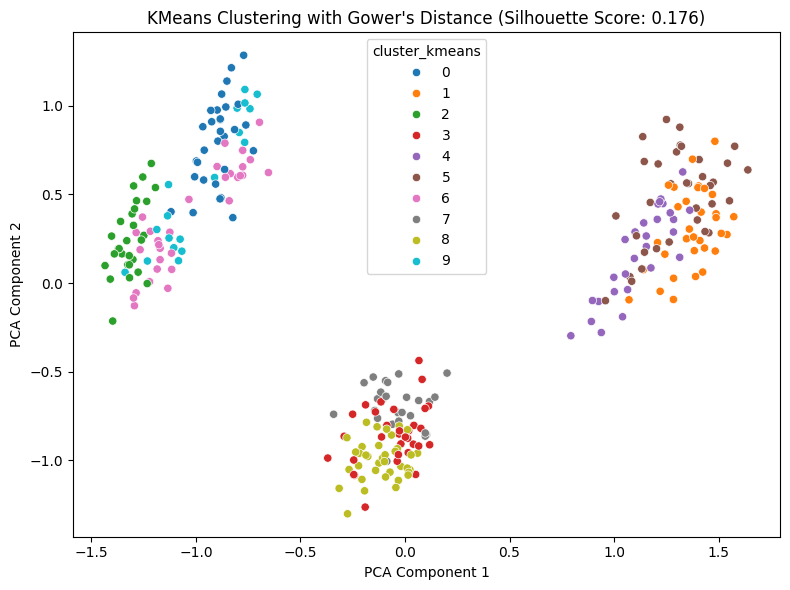

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=10, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/kmeans1.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_kmeans
8    39
5    34
1    33
3    32
6    32
0    30
4    28
2    28
7    26
9    18
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 30
Cluster 1: 33
Cluster 2: 28
Cluster 3: 32
Cluster 4: 28
Cluster 5: 34
Cluster 6: 32
Cluster 7: 26
Cluster 8: 39
Cluster 9: 18


In [ ]:
from datetime import timedelta
import pandas as pd

def evaluate_clustering(csv_path, cluster_col="cluster_kmeans"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  # € for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Kmeans variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}\n")

        group_sizes = carpool_df.groupby("carpool_group_id")["person_id"].count()
        print("People per group:")
        for group_id, count in group_sizes.items():
            print(f"{group_id}: {count}")

        print("\nDistribution of group sizes:")
        print(group_sizes.value_counts().sort_index())

    else:
        print("No carpool groups.")


In [ ]:
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/kmeans1.csv", cluster_col="cluster_kmeans")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/kmeans1.csv
Number of groups: 56
Total cost: €48532
Total CO2 emission: 7835.78 kg
CO2 tax: €349.48

People per group:
group_1: 2
group_10: 3
group_11: 2
group_12: 3
group_13: 1
group_14: 2
group_15: 2
group_16: 2
group_17: 2
group_18: 3
group_19: 2
group_2: 3
group_20: 2
group_21: 2
group_22: 2
group_23: 2
group_24: 2
group_25: 2
group_26: 2
group_27: 2
group_28: 3
group_29: 3
group_3: 2
group_30: 2
group_31: 3
group_32: 4
group_33: 1
group_34: 2
group_35: 2
group_36: 2
group_37: 2
group_38: 2
group_39: 2
group_4: 2
group_40: 2
group_41: 4
group_42: 2
group_43: 4
group_44: 1
group_45: 1
group_46: 5
group_47: 1
group_48: 2
group_49: 2
group_5: 2
group_50: 2
group_51: 2
group_52: 2
group_53: 4
group_54: 3
group_55: 3
group_56: 2
group_6: 2
group_7: 2
group_8: 2
group_9: 4

Distribution of group sizes:
person_id
1     5
2    36
3     9
4     5
5     1
Name: count, dtype: int64


## Optimization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/kmeans1.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_kmeans"].unique():
    cluster_df = df[df["cluster_kmeans"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedkmeans1.csv", index=True)
print(group_stats.head(10))


4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                       197.045                 3219   
group_10                      252.595                 3607   
group_11                       99.210                 1841   
group_12                        6.144                 3217   
group_13                        4.488                  984   
group_14                       10.068                 1008   
group_15                      170.220       

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedkmeans1.csv")

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 197.04 kg
Total cost: 3219.00 €

1
Number of people in group: 3
Optimized transport type: car
Total CO₂: 252.59 kg
Total cost: 3607.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 99.21 kg
Total cost: 1841.00 €

3
Number of people in group: 3
Optimized transport type: train
Total CO₂: 6.14 kg
Total cost: 3217.00 €

4
Number of people in group: 1
Optimized transport type: train
Total CO₂: 4.49 kg
Total cost: 984.00 €

5
Number of people in group: 2
Optimized transport type: train
Total CO₂: 10.07 kg
Total cost: 1008.00 €

6
Number of people in group: 2
Optimized transport type: car
Total CO₂: 170.22 kg
Total cost: 2188.00 €

7
Number of people in group: 2
Optimized transport type: car
Total CO₂: 167.64 kg
Total cost: 2241.00 €

8
Number of people in group: 2
Optimized transport type: car
Total CO₂: 120.20 kg
Total cost: 903.00 €

9
Number of people in group: 3
Optimized transport type: 

# Kmeans with k=15, changed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]

df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


Silhouette Score: 0.163


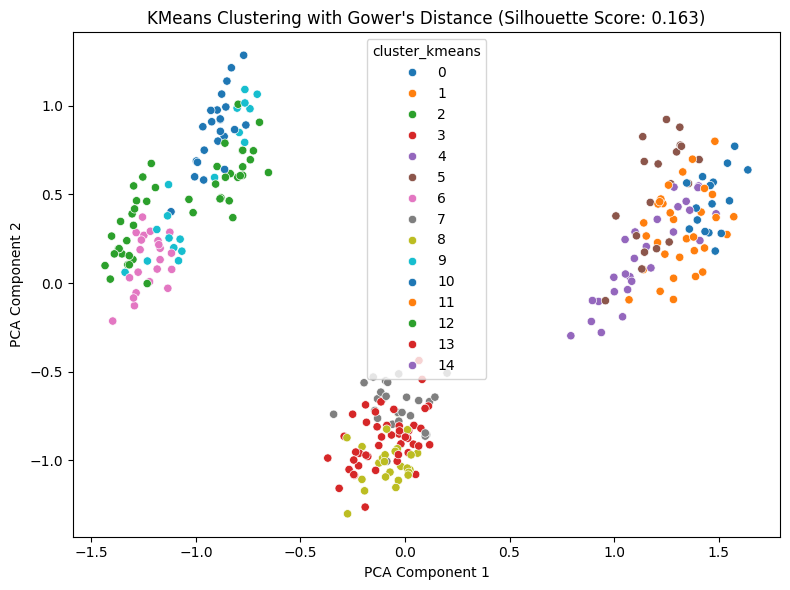

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=15, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/kmeans2.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 15
Cluster sizes:
 cluster_kmeans
13    32
7     26
8     25
2     23
0     23
1     22
12    22
6     22
5     19
9     18
10    16
14    15
3     14
4     12
11    11
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 23
Cluster 1: 22
Cluster 2: 23
Cluster 3: 14
Cluster 4: 12
Cluster 5: 19
Cluster 6: 22
Cluster 7: 26
Cluster 8: 25
Cluster 9: 18
Cluster 10: 16
Cluster 11: 11
Cluster 12: 22
Cluster 13: 32
Cluster 14: 15


In [ ]:
from datetime import timedelta
import pandas as pd

def evaluate_clustering(csv_path, cluster_col="cluster_kmeans"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  # € for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Kmeans variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}\n")

        group_sizes = carpool_df.groupby("carpool_group_id")["person_id"].count()
        print("People per group:")
        for group_id, count in group_sizes.items():
            print(f"{group_id}: {count}")

        print("\nDistribution of group sizes:")
        print(group_sizes.value_counts().sort_index())

    else:
        print("No carpool groups.")


In [ ]:
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/kmeans2.csv", cluster_col="cluster_kmeans")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/kmeans2.csv
Number of groups: 43
Total cost: €36613
Total CO2 emission: 5633.96 kg
CO2 tax: €251.27

People per group:
group_1: 2
group_10: 2
group_11: 2
group_12: 2
group_13: 2
group_14: 2
group_15: 2
group_16: 4
group_17: 2
group_18: 3
group_19: 2
group_2: 3
group_20: 3
group_21: 2
group_22: 2
group_23: 2
group_24: 2
group_25: 2
group_26: 3
group_27: 3
group_28: 4
group_29: 1
group_3: 2
group_30: 2
group_31: 3
group_32: 2
group_33: 3
group_34: 3
group_35: 2
group_36: 2
group_37: 2
group_38: 2
group_39: 2
group_4: 2
group_40: 2
group_41: 2
group_42: 2
group_43: 2
group_5: 2
group_6: 2
group_7: 2
group_8: 2
group_9: 2

Distribution of group sizes:
person_id
1     1
2    32
3     8
4     2
Name: count, dtype: int64


## Optimization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/kmeans2.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_kmeans"].unique():
    cluster_df = df[df["cluster_kmeans"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedkmeans2.csv", index=True)
print(group_stats.head(10))


4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                       197.045                 3219   
group_10                      155.015                 2232   
group_11                        6.864                 1497   
group_12                      172.380                 1337   
group_13                       81.530                 1664   
group_14                       67.110                 1708   
group_15                      162.410                 1205   
group_16                       28.632                 3092   
group_17    

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedkmeans2.csv")

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 197.04 kg
Total cost: 3219.00 €

1
Number of people in group: 2
Optimized transport type: car
Total CO₂: 155.01 kg
Total cost: 2232.00 €

2
Number of people in group: 2
Optimized transport type: train
Total CO₂: 6.86 kg
Total cost: 1497.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 172.38 kg
Total cost: 1337.00 €

4
Number of people in group: 2
Optimized transport type: car
Total CO₂: 81.53 kg
Total cost: 1664.00 €

5
Number of people in group: 2
Optimized transport type: car
Total CO₂: 67.11 kg
Total cost: 1708.00 €

6
Number of people in group: 2
Optimized transport type: car
Total CO₂: 162.41 kg
Total cost: 1205.00 €

7
Number of people in group: 4
Optimized transport type: train
Total CO₂: 28.63 kg
Total cost: 3092.00 €

8
Number of people in group: 2
Optimized transport type: train
Total CO₂: 13.97 kg
Total cost: 1450.00 €

9
Number of people in group: 3
Optimized transport type

# Kmeans with k=30, changed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]

df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


Silhouette Score: 0.181


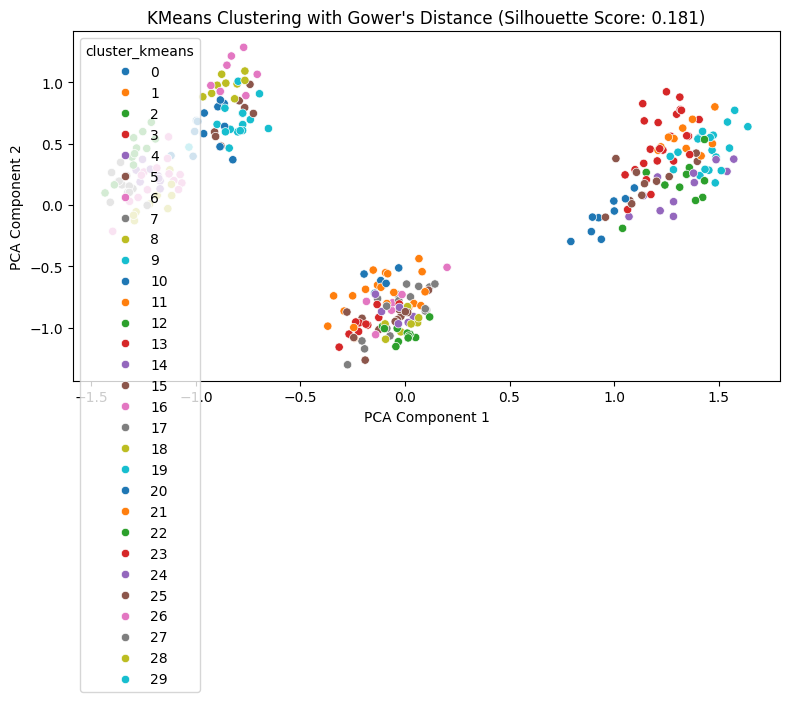

In [ ]:
#calculate Gower's Distance because assistant mentioned to use this
gower_matrix = gower.gower_matrix(df_encoded)

#KMeans Clustering with Gower's Distance
kmeans = KMeans(n_clusters=30, random_state=42)
kmeans.fit(gower_matrix)

df['cluster_kmeans'] = kmeans.labels_

#evaluating Clustering with Silhouette Score
silhouette_avg = silhouette_score(gower_matrix, kmeans.labels_)
print(f"Silhouette Score: {silhouette_avg:.3f}")

#applying PCA for visualization to get best variables visualized
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

#plotting the clusters after PCA transformation
plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df['cluster_kmeans'], palette="tab10")
plt.title(f"KMeans Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.tight_layout()
plt.show()


In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/kmeans3.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_kmeans'].nunique())
print("Cluster sizes:\n", df['cluster_kmeans'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_kmeans
29    16
26    15
11    15
23    13
0     13
17    12
19    12
14    12
25    12
27    12
12    11
2     11
13    11
5     11
22    10
3     10
1     10
8      9
18     9
10     9
6      8
4      8
15     7
16     7
9      7
28     7
7      6
20     6
24     6
21     5
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_kmeans'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 13
Cluster 1: 10
Cluster 2: 11
Cluster 3: 10
Cluster 4: 8
Cluster 5: 11
Cluster 6: 8
Cluster 7: 6
Cluster 8: 9
Cluster 9: 7
Cluster 10: 9
Cluster 11: 15
Cluster 12: 11
Cluster 13: 11
Cluster 14: 12
Cluster 15: 7
Cluster 16: 7
Cluster 17: 12
Cluster 18: 9
Cluster 19: 12
Cluster 20: 6
Cluster 21: 5
Cluster 22: 10
Cluster 23: 13
Cluster 24: 6
Cluster 25: 12
Cluster 26: 15
Cluster 27: 12
Cluster 28: 7
Cluster 29: 16


In [ ]:
from datetime import timedelta
import pandas as pd

def evaluate_clustering(csv_path, cluster_col="cluster_kmeans"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  # € for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Kmeans variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}\n")

        group_sizes = carpool_df.groupby("carpool_group_id")["person_id"].count()
        print("People per group:")
        for group_id, count in group_sizes.items():
            print(f"{group_id}: {count}")

        print("\nDistribution of group sizes:")
        print(group_sizes.value_counts().sort_index())

    else:
        print("No carpool groups.")


In [ ]:
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/kmeans3.csv", cluster_col="cluster_kmeans")


Kmeans variant: /content/drive/MyDrive/Master IoT/Tutor project/kmeans3.csv
Number of groups: 42
Total cost: €34799
Total CO2 emission: 5694.83 kg
CO2 tax: €253.99

People per group:
group_1: 2
group_10: 2
group_11: 2
group_12: 2
group_13: 3
group_14: 3
group_15: 2
group_16: 3
group_17: 2
group_18: 2
group_19: 2
group_2: 3
group_20: 2
group_21: 2
group_22: 2
group_23: 2
group_24: 2
group_25: 3
group_26: 1
group_27: 3
group_28: 2
group_29: 2
group_3: 4
group_30: 2
group_31: 2
group_32: 2
group_33: 2
group_34: 2
group_35: 3
group_36: 2
group_37: 3
group_38: 2
group_39: 2
group_4: 1
group_40: 2
group_41: 2
group_42: 2
group_5: 3
group_6: 2
group_7: 2
group_8: 4
group_9: 1

Distribution of group sizes:
person_id
1     3
2    28
3     9
4     2
Name: count, dtype: int64


## Optimization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/kmeans3.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_kmeans"].unique():
    cluster_df = df[df["cluster_kmeans"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedkmeans3.csv", index=True)
print(group_stats.head(10))


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
4.0
4.0
5.0
5.0
4.0
5.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                       154.035                 3146   
group_10                       13.968                 1450   
group_11                      181.530                 2211   
group_12                       99.210                 1841   
group_13                       14.772                 3439   
group_14                      203.045                 1924   
group_15                       94.400                 1223   
group_16                      138.330                 3626   
group_17            

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedkmeans3.csv")

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 154.04 kg
Total cost: 3146.00 €

1
Number of people in group: 2
Optimized transport type: train
Total CO₂: 13.97 kg
Total cost: 1450.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 181.53 kg
Total cost: 2211.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 99.21 kg
Total cost: 1841.00 €

4
Number of people in group: 3
Optimized transport type: train
Total CO₂: 14.77 kg
Total cost: 3439.00 €

5
Number of people in group: 3
Optimized transport type: car
Total CO₂: 203.04 kg
Total cost: 1924.00 €

6
Number of people in group: 2
Optimized transport type: car
Total CO₂: 94.40 kg
Total cost: 1223.00 €

7
Number of people in group: 3
Optimized transport type: car
Total CO₂: 138.33 kg
Total cost: 3626.00 €

8
Number of people in group: 2
Optimized transport type: car
Total CO₂: 43.82 kg
Total cost: 663.00 €

9
Number of people in group: 2
Optimized transport type: 

When using k=10, the optimization resulted in a total cost of €122,732 and CO₂ emissions of 5,493.78 kg. Although this setting created fewer groups, the optimization was inefficient due to large and inflexible clusters, which limited the ability to match travelers efficiently. With k=15, we observed a noticeable improvement—CO₂ emissions dropped to 4,092.21 kg, and the total cost decreased to €92,413. This setting allowed for better granularity and flexibility while keeping the group sizes reasonable. However, the most efficient results were achieved with k=30, where the optimization yielded the lowest total cost of €86,899 and the lowest CO₂ output of 3,921.70 kg. This suggests that finer clustering allowed the algorithm to form more tailored carpooling groups, minimizing unnecessary vehicle usage and travel mismatches.

Based on these findings, k=30 offers the best balance between economic and environmental efficiency, and will serve as the reference point for comparison with the AGNES clustering method in the next stage of analysis.

# Agnes with n=10, changed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]

df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.317


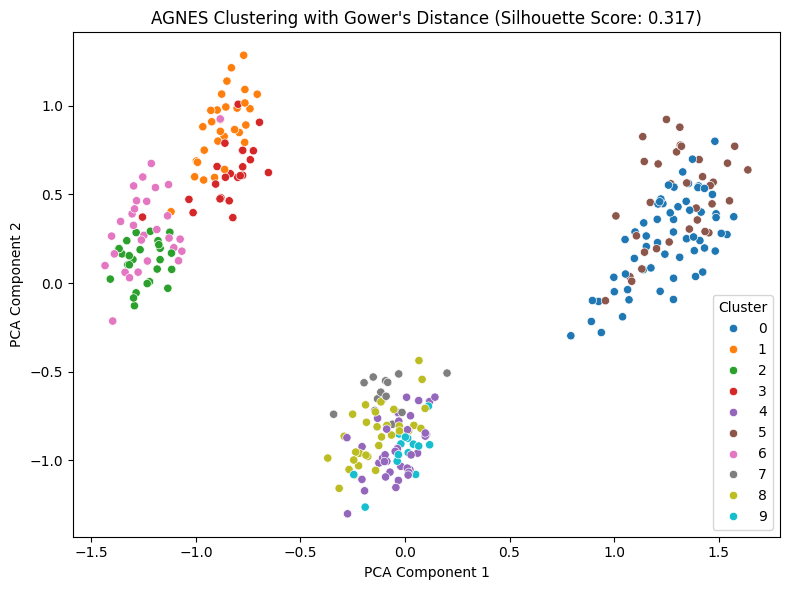

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=10, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/agnes1.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 10
Cluster sizes:
 cluster_agnes
0    61
4    37
5    34
8    32
1    30
6    29
2    26
3    23
7    14
9    14
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 61
Cluster 1: 30
Cluster 2: 26
Cluster 3: 23
Cluster 4: 37
Cluster 5: 34
Cluster 6: 29
Cluster 7: 14
Cluster 8: 32
Cluster 9: 14


In [ ]:
from datetime import timedelta
import pandas as pd

def evaluate_clustering(csv_path, cluster_col="cluster_agnes"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  # € for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Agnes variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}\n")

        group_sizes = carpool_df.groupby("carpool_group_id")["person_id"].count()
        print("People per group:")
        for group_id, count in group_sizes.items():
            print(f"{group_id}: {count}")

        print("\nDistribution of group sizes:")
        print(group_sizes.value_counts().sort_index())

    else:
        print("No carpool groups.")


In [ ]:
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/agnes1.csv", cluster_col="cluster_agnes")


Agnes variant: /content/drive/MyDrive/Master IoT/Tutor project/agnes1.csv
Number of groups: 49
Total cost: €40259
Total CO2 emission: 6648.67 kg
CO2 tax: €296.53

People per group:
group_1: 2
group_10: 2
group_11: 2
group_12: 2
group_13: 2
group_14: 3
group_15: 2
group_16: 2
group_17: 3
group_18: 3
group_19: 3
group_2: 2
group_20: 2
group_21: 2
group_22: 3
group_23: 2
group_24: 2
group_25: 2
group_26: 2
group_27: 2
group_28: 2
group_29: 2
group_3: 2
group_30: 2
group_31: 4
group_32: 3
group_33: 3
group_34: 2
group_35: 2
group_36: 2
group_37: 3
group_38: 3
group_39: 2
group_4: 1
group_40: 3
group_41: 4
group_42: 1
group_43: 2
group_44: 3
group_45: 2
group_46: 3
group_47: 2
group_48: 2
group_49: 2
group_5: 2
group_6: 1
group_7: 4
group_8: 1
group_9: 2

Distribution of group sizes:
person_id
1     4
2    30
3    12
4     3
Name: count, dtype: int64


## Optimization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/agnes1.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_agnes"].unique():
    cluster_df = df[df["cluster_agnes"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedagnes1.csv", index=True)
print(group_stats.head(10))


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                        84.690                 1007   
group_10                      154.035                 3146   
group_11                      102.270                 2807   
group_12                      155.015                 2232   
group_13                        6.864                 1497   
group_14                      272.490                 1290   
group_15                       11.544           

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedagnes1.csv")

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 84.69 kg
Total cost: 1007.00 €

1
Number of people in group: 2
Optimized transport type: car
Total CO₂: 154.04 kg
Total cost: 3146.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 102.27 kg
Total cost: 2807.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 155.01 kg
Total cost: 2232.00 €

4
Number of people in group: 2
Optimized transport type: train
Total CO₂: 6.86 kg
Total cost: 1497.00 €

5
Number of people in group: 3
Optimized transport type: car
Total CO₂: 272.49 kg
Total cost: 1290.00 €

6
Number of people in group: 2
Optimized transport type: train
Total CO₂: 11.54 kg
Total cost: 1470.00 €

7
Number of people in group: 2
Optimized transport type: car
Total CO₂: 96.53 kg
Total cost: 1107.00 €

8
Number of people in group: 3
Optimized transport type: car
Total CO₂: 203.04 kg
Total cost: 1924.00 €

9
Number of people in group: 3
Optimized transport type:

# Agnes with n=15, changed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]

df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.330


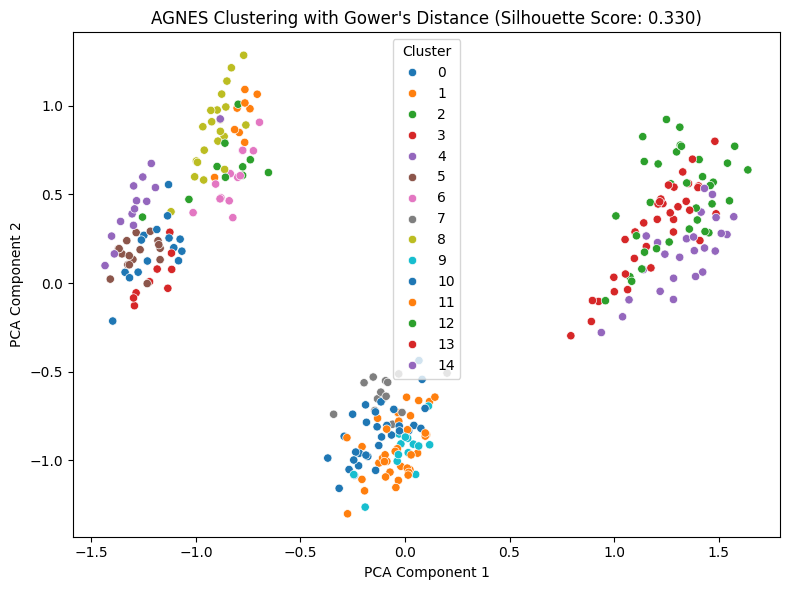

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=15, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/agnes2.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 15
Cluster sizes:
 cluster_agnes
1     37
3     35
2     34
0     32
4     26
8     21
5     17
10    15
14    14
7     14
9     14
6     13
12    10
13     9
11     9
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 32
Cluster 1: 37
Cluster 2: 34
Cluster 3: 35
Cluster 4: 26
Cluster 5: 17
Cluster 6: 13
Cluster 7: 14
Cluster 8: 21
Cluster 9: 14
Cluster 10: 15
Cluster 11: 9
Cluster 12: 10
Cluster 13: 9
Cluster 14: 14


In [ ]:
from datetime import timedelta
import pandas as pd

def evaluate_clustering(csv_path, cluster_col="cluster_agnes"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  # € for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Agnes variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}\n")

        group_sizes = carpool_df.groupby("carpool_group_id")["person_id"].count()
        print("People per group:")
        for group_id, count in group_sizes.items():
            print(f"{group_id}: {count}")

        print("\nDistribution of group sizes:")
        print(group_sizes.value_counts().sort_index())

    else:
        print("No carpool groups.")


In [ ]:
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/agnes2.csv", cluster_col="cluster_agnes")


Agnes variant: /content/drive/MyDrive/Master IoT/Tutor project/agnes2.csv
Number of groups: 46
Total cost: €36012
Total CO2 emission: 5820.54 kg
CO2 tax: €259.6

People per group:
group_1: 2
group_10: 2
group_11: 2
group_12: 2
group_13: 2
group_14: 3
group_15: 2
group_16: 2
group_17: 2
group_18: 2
group_19: 2
group_2: 2
group_20: 2
group_21: 2
group_22: 2
group_23: 2
group_24: 2
group_25: 2
group_26: 2
group_27: 3
group_28: 3
group_29: 2
group_3: 2
group_30: 3
group_31: 4
group_32: 1
group_33: 2
group_34: 3
group_35: 2
group_36: 3
group_37: 2
group_38: 2
group_39: 2
group_4: 1
group_40: 2
group_41: 2
group_42: 2
group_43: 2
group_44: 2
group_45: 2
group_46: 2
group_5: 2
group_6: 1
group_7: 4
group_8: 1
group_9: 2

Distribution of group sizes:
person_id
1     4
2    34
3     6
4     2
Name: count, dtype: int64


## Optimization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/agnes2.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_agnes"].unique():
    cluster_df = df[df["cluster_agnes"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedagnes2.csv", index=True)
print(group_stats.head(10))


5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
4.0
4.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                        84.690                 1007   
group_10                      154.035                 3146   
group_11                      102.270                 2807   
group_12                      155.015                 2232   
group_13                        6.864                 1497   
group_14                      272.490                 1290   
group_15                       11.544                 1470   
group_16                      

<ipython-input-172-4e72473ba112>:58: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
<ipython-input-172-4e72473ba112>:59: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  final["days"] = final["days"].clip(lower=1)
<ipython-input-172-4e72473ba112>:60: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedagnes2.csv")

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 84.69 kg
Total cost: 1007.00 €

1
Number of people in group: 2
Optimized transport type: car
Total CO₂: 154.04 kg
Total cost: 3146.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 102.27 kg
Total cost: 2807.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 155.01 kg
Total cost: 2232.00 €

4
Number of people in group: 2
Optimized transport type: train
Total CO₂: 6.86 kg
Total cost: 1497.00 €

5
Number of people in group: 3
Optimized transport type: car
Total CO₂: 272.49 kg
Total cost: 1290.00 €

6
Number of people in group: 2
Optimized transport type: train
Total CO₂: 11.54 kg
Total cost: 1470.00 €

7
Number of people in group: 2
Optimized transport type: car
Total CO₂: 96.53 kg
Total cost: 1107.00 €

8
Number of people in group: 2
Optimized transport type: car
Total CO₂: 149.40 kg
Total cost: 1551.00 €

9
Number of people in group: 2
Optimized transport type:

# Agnes with n=30, changed

In [ ]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score
import gower
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import OneHotEncoder

Aftrer importing, we are using just the most relevant features to make clustering groups.

In [ ]:
missions = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/allmissions.csv")
persons = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/personsnew.csv")
co2 = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")


We need to merge csvs and filter out real moves

In [ ]:
df = missions.merge(persons, on="person_id", how="left")
df = df.merge(co2, on="car_model", how="left")
df = df[df["real_move"] == True].copy()

df["start_date"] = pd.to_datetime(df["start_date"])
df["start_hour"] = df["start_date"].dt.hour
df["is_return_trip"] = df["is_return_trip"].astype(int)


In [ ]:
#now we select only the most relevant features for clustering
features = [
    "start_city", "end_city", "travel_type", "vehicle_type", "has_car",
    "car_capacity", "start_hour", "km", "total_cost", "co2_per_km", "is_return_trip"
]

df_selected = df[features].copy()

In [ ]:
df_selected["car_capacity"] = df_selected["car_capacity"].fillna(1)
df_selected["co2_per_km"] = df_selected["co2_per_km"].fillna(df_selected["co2_per_km"].mean())

#OneHotEncode for 'is return trip' because it is categorical variable
categorical_cols = ["start_city", "end_city", "travel_type", "vehicle_type", "has_car", "is_return_trip"]
numerical_cols = ["car_capacity", "start_hour", "km", "total_cost", "co2_per_km"]

encoder = OneHotEncoder(drop="first", sparse_output=False)
encoded_cats = pd.DataFrame(encoder.fit_transform(df_selected[categorical_cols]), columns=encoder.get_feature_names_out(categorical_cols))

#combining 'is return trip' column with the numerical features
scaler = StandardScaler()
scaled_nums = pd.DataFrame(scaler.fit_transform(df_selected[numerical_cols]), columns=numerical_cols)

# Final combined features for clustering
df_encoded = pd.concat([encoded_cats.reset_index(drop=True), scaled_nums.reset_index(drop=True)], axis=1)


/usr/local/lib/python3.11/dist-packages/sklearn/cluster/_agglomerative.py:588: ClusterWarning: The symmetric non-negative hollow observation matrix looks suspiciously like an uncondensed distance matrix
  out = hierarchy.linkage(X, method=linkage, metric=affinity)


Silhouette Score: 0.356


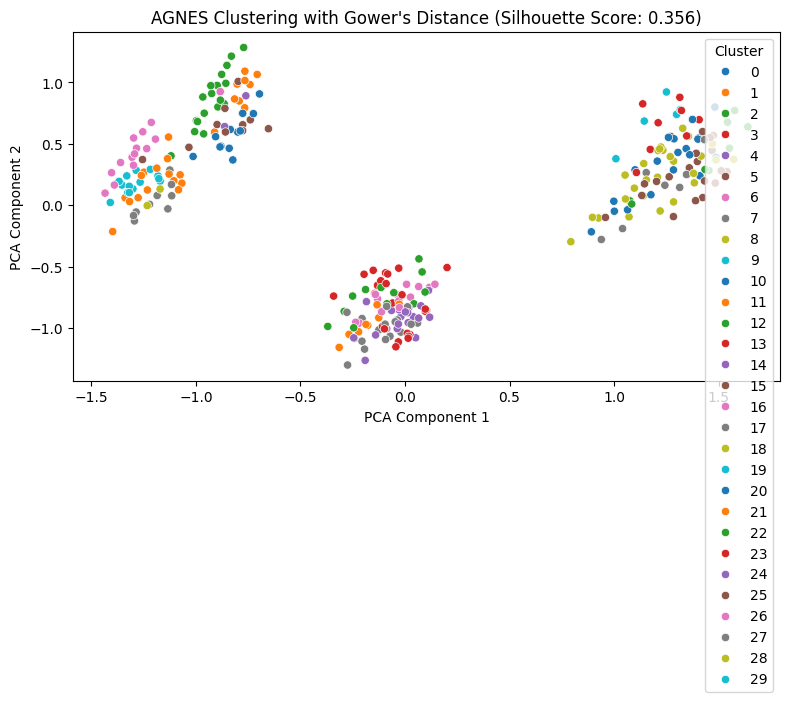

In [ ]:
gower_matrix = gower.gower_matrix(df_encoded)

#AGNES clustering
agnes = AgglomerativeClustering(n_clusters=30, metric='cosine', linkage='average')
labels = agnes.fit_predict(gower_matrix)
df["cluster_agnes"] = labels

silhouette_avg = silhouette_score(gower_matrix, labels, metric="cosine")
print(f"Silhouette Score: {silhouette_avg:.3f}")

#PCA for visualization
pca = PCA(n_components=2)
pca_components = pca.fit_transform(gower_matrix)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=pca_components[:, 0], y=pca_components[:, 1], hue=df["cluster_agnes"], palette="tab10")
plt.title(f"AGNES Clustering with Gower's Distance (Silhouette Score: {silhouette_avg:.3f})")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.legend(title="Cluster")
plt.tight_layout()
plt.show()

In [ ]:
df.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/agnes3.csv", index=False)

In [ ]:
print("Number of unique clusters:", df['cluster_agnes'].nunique())
print("Cluster sizes:\n", df['cluster_agnes'].value_counts())

Number of unique clusters: 30
Cluster sizes:
 cluster_agnes
2     19
0     19
7     17
8     16
1     15
4     14
3     14
6     14
15    13
12    13
23    11
18    11
5     10
9     10
11     9
27     9
16     9
22     8
25     8
13     8
21     8
20     7
17     7
10     6
14     6
19     5
29     5
26     5
24     2
28     2
Name: count, dtype: int64


In [ ]:
cluster_sizes = df['cluster_agnes'].value_counts().sort_index()

print("number of people:\n")
for cluster_id, count in cluster_sizes.items():
    print(f"Cluster {cluster_id}: {count}")


number of people:

Cluster 0: 19
Cluster 1: 15
Cluster 2: 19
Cluster 3: 14
Cluster 4: 14
Cluster 5: 10
Cluster 6: 14
Cluster 7: 17
Cluster 8: 16
Cluster 9: 10
Cluster 10: 6
Cluster 11: 9
Cluster 12: 13
Cluster 13: 8
Cluster 14: 6
Cluster 15: 13
Cluster 16: 9
Cluster 17: 7
Cluster 18: 11
Cluster 19: 5
Cluster 20: 7
Cluster 21: 8
Cluster 22: 8
Cluster 23: 11
Cluster 24: 2
Cluster 25: 8
Cluster 26: 5
Cluster 27: 9
Cluster 28: 2
Cluster 29: 5


In [ ]:
from datetime import timedelta
import pandas as pd

def evaluate_clustering(csv_path, cluster_col="cluster_agnes"):
    df = pd.read_csv(csv_path)
    df["start_date"] = pd.to_datetime(df["start_date"])

    df["co2_emission_kg"] = df["km"] * df["co2_per_km"]

    carbon_tax_rate = 0.0446  # € for kg CO₂
    carpool_groups = []
    used = set()
    group_id = 1

    for cluster in df[cluster_col].unique():
        cluster_df = df[df[cluster_col] == cluster]

        for (start_city, end_city), group in cluster_df.groupby(["start_city", "end_city"]):
            group = group.sort_values("start_date")

            for i in range(len(group)):
                if i in used:
                    continue

                driver = group.iloc[i]
                if not driver.get("has_car", False) or pd.isna(driver.get("car_capacity")):
                    continue

                carpool_group = [driver]
                used.add(driver.name)
                capacity_left = int(driver["car_capacity"]) - 1

                candidates = group[
                    (~group.index.isin(used)) &
                    (group["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                    (group["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                    (group["person_id"] != driver["person_id"])
                ]

                for _, passenger in candidates.iterrows():
                    if capacity_left <= 0:
                        break
                    carpool_group.append(passenger)
                    used.add(passenger.name)
                    capacity_left -= 1

                if len(carpool_group) > 1:
                    group_df = pd.DataFrame(carpool_group)
                    group_df["carpool_group_id"] = f"group_{group_id}"
                    carpool_groups.append(group_df)
                    group_id += 1

    if carpool_groups:
        carpool_df = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
        total_cost = carpool_df["total_cost"].sum()
        total_co2 = carpool_df["co2_emission_kg"].sum()
        co2_tax = total_co2 * carbon_tax_rate

        print(f"Agnes variant: {csv_path}")
        print(f"Number of groups: {len(carpool_df['carpool_group_id'].unique())}")
        print(f"Total cost: €{round(total_cost, 2)}")
        print(f"Total CO2 emission: {round(total_co2, 2)} kg")
        print(f"CO2 tax: €{round(co2_tax, 2)}\n")

        group_sizes = carpool_df.groupby("carpool_group_id")["person_id"].count()
        print("People per group:")
        for group_id, count in group_sizes.items():
            print(f"{group_id}: {count}")

        print("\nDistribution of group sizes:")
        print(group_sizes.value_counts().sort_index())

    else:
        print("No carpool groups.")


In [ ]:
evaluate_clustering("/content/drive/MyDrive/Master IoT/Tutor project/agnes3.csv", cluster_col="cluster_agnes")


Agnes variant: /content/drive/MyDrive/Master IoT/Tutor project/agnes3.csv
Number of groups: 44
Total cost: €34799
Total CO2 emission: 5591.02 kg
CO2 tax: €249.36

People per group:
group_1: 2
group_10: 2
group_11: 2
group_12: 2
group_13: 2
group_14: 2
group_15: 2
group_16: 2
group_17: 2
group_18: 2
group_19: 2
group_2: 1
group_20: 3
group_21: 2
group_22: 2
group_23: 2
group_24: 2
group_25: 2
group_26: 3
group_27: 2
group_28: 2
group_29: 3
group_3: 4
group_30: 1
group_31: 1
group_32: 3
group_33: 3
group_34: 4
group_35: 1
group_36: 2
group_37: 3
group_38: 2
group_39: 2
group_4: 1
group_40: 2
group_41: 2
group_42: 2
group_43: 2
group_44: 2
group_5: 2
group_6: 2
group_7: 2
group_8: 2
group_9: 3

Distribution of group sizes:
person_id
1     5
2    30
3     7
4     2
Name: count, dtype: int64


## Optimization

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/agnes3.csv")
co2_df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/dataset/co22.csv")

df["start_date"] = pd.to_datetime(df["start_date"])
df["end_date"] = pd.to_datetime(df["end_date"])
df["is_return_trip"] = df["is_return_trip"].astype(int)
df["real_move"] = df["real_move"].fillna(True)
df = df[df["real_move"] == True].copy()

df["car_model"] = df["car_model"].fillna("average_carpool")
df = df.merge(co2_df[["car_model", "car_type", "co2_per_km"]], on="car_model", how="left")

#here we are forming carpool groups and verify if capacity of car is full, if there is driver
carpool_groups = []
used = set()
group_id = 1

for cluster in df["cluster_agnes"].unique():
    cluster_df = df[df["cluster_agnes"] == cluster]

    for (start_city, end_city), route_df in cluster_df.groupby(["start_city", "end_city"]):
        route_df = route_df.sort_values("start_date")

        for i in range(len(route_df)):
            if i in used:
                continue

            driver = route_df.iloc[i]
            if not driver["has_car"] or pd.isna(driver["car_capacity"]):
                continue
            print(driver["car_capacity"])
            carpool_group = [driver]
            used.add(driver.name)
            capacity_left = int(driver["car_capacity"]) - 1

            candidates = route_df[
                (~route_df.index.isin(used)) &
                (route_df["start_date"] >= driver["start_date"] - timedelta(days=2)) &
                (route_df["start_date"] <= driver["start_date"] + timedelta(days=2)) &
                (route_df["person_id"] != driver["person_id"])
            ]

            for _, passenger in candidates.iterrows():
                if capacity_left <= 0:
                    break
                carpool_group.append(passenger)
                used.add(passenger.name)
                capacity_left -= 1

            if len(carpool_group) > 1:
                group_df = pd.DataFrame(carpool_group)
                group_df["carpool_group_id"] = f"group_{group_id}"
                carpool_groups.append(group_df)
                group_id += 1

#analyse of groups
final = pd.concat(carpool_groups).drop_duplicates(subset=["mission_id"])
final["days"] = (final["end_date"] - final["start_date"]).dt.days + 1
final["days"] = final["days"].clip(lower=1)
final["co2_total"] = final["co2_per_km_y"] * final["km"]
final["hotel_total"] = final["hotel_cost"] * final["days"]
final["total_trip_cost"] = final["hotel_total"] + final["total_cost"]

#after that part of optimization we want to change car with train if it's faster to reduce co2
train_durations = {
    ("Belfort", "Nice"): 5, ("Besançon", "Marseille"): 4.5,
    ("Montbéliard", "Strasbourg"): 1.5, ("Montbéliard", "Toulouse"): 5,
    ("Belfort", "Paris"): 3, ("Besançon", "Toulouse"): 5.5,
    ("Montbéliard", "Nice"): 5, ("Montbéliard", "Lyon"): 2,
    ("Belfort", "Marseille"): 4.5, ("Besançon", "Nice"): 5,
    ("Besançon", "Strasbourg"): 1.5
}

car_durations = {
    ("Belfort", "Nice"): 8, ("Besançon", "Marseille"): 7,
    ("Montbéliard", "Strasbourg"): 2, ("Montbéliard", "Toulouse"): 8,
    ("Belfort", "Paris"): 6, ("Besançon", "Toulouse"): 7,
    ("Montbéliard", "Nice"): 7, ("Montbéliard", "Lyon"): 3,
    ("Belfort", "Marseille"): 7, ("Besançon", "Nice"): 8,
    ("Besançon", "Strasbourg"): 2.5
}

co2_train = co2_df[co2_df["car_model"] == "TER"]["co2_per_km"].values[0]

final["travel_mode_optimized"] = "car"
for (start, end), car_time in car_durations.items():
    if (start, end) in train_durations:
        train_time = train_durations[(start, end)]
        if car_time - train_time >= 2:
            final.loc[(final["start_city"] == start) & (final["end_city"] == end), "travel_mode_optimized"] = "train"

final["optimized_co2_per_km"] = final.apply(
    lambda row: co2_train if row["travel_mode_optimized"] == "train" else row["co2_per_km_y"],
    axis=1
)

final["optimized_trip_cost"] = final["hotel_cost"] * final["days"] + final["total_cost"]
final["optimized_co2_total"] = final["optimized_co2_per_km"] * final["km"]

#interpretation of reuslts and saving results in file
group_stats = final.groupby("carpool_group_id").agg({
    "optimized_co2_total": "sum",
    "optimized_trip_cost": "sum",
    "travel_mode_optimized": lambda x: x.mode()[0],
    "person_id": "count"
}).rename(columns={"person_id": "number_of_people"})

group_stats.to_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedagnes3.csv", index=True)
print(group_stats.head(10))


5.0
5.0
4.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
4.0
4.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
5.0
4.0
5.0
5.0
5.0
5.0
5.0
4.0
                  optimized_co2_total  optimized_trip_cost  \
carpool_group_id                                             
group_1                        78.700                 2524   
group_10                       11.544                 1470   
group_11                       96.535                 1107   
group_12                      233.960                 1705   
group_13                      172.380                 1337   
group_14                       81.530                 1664   
group_15                       83.20

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Master IoT/Tutor project/optimizedagnes3.csv")

for group_id, row in df.iterrows():
    print(f"{group_id}")
    print(f"Number of people in group: {int(row['number_of_people'])}")
    print(f"Optimized transport type: {row['travel_mode_optimized']}")
    print(f"Total CO₂: {row['optimized_co2_total']:.2f} kg")
    print(f"Total cost: {row['optimized_trip_cost']:.2f} €\n")

total_cost = df["optimized_trip_cost"].sum()
total_co2 = df["optimized_co2_total"].sum()
print("==== TOTALS ====")
print(f"Total cost for all groups: {total_cost:.2f} €")
print(f"Total CO₂ emissions for all groups: {total_co2:.2f} kg")


0
Number of people in group: 2
Optimized transport type: car
Total CO₂: 78.70 kg
Total cost: 2524.00 €

1
Number of people in group: 2
Optimized transport type: train
Total CO₂: 11.54 kg
Total cost: 1470.00 €

2
Number of people in group: 2
Optimized transport type: car
Total CO₂: 96.53 kg
Total cost: 1107.00 €

3
Number of people in group: 2
Optimized transport type: car
Total CO₂: 233.96 kg
Total cost: 1705.00 €

4
Number of people in group: 2
Optimized transport type: car
Total CO₂: 172.38 kg
Total cost: 1337.00 €

5
Number of people in group: 2
Optimized transport type: car
Total CO₂: 81.53 kg
Total cost: 1664.00 €

6
Number of people in group: 2
Optimized transport type: car
Total CO₂: 83.20 kg
Total cost: 1060.00 €

7
Number of people in group: 2
Optimized transport type: car
Total CO₂: 181.53 kg
Total cost: 2211.00 €

8
Number of people in group: 2
Optimized transport type: car
Total CO₂: 99.21 kg
Total cost: 1841.00 €

9
Number of people in group: 2
Optimized transport type: ca

When using n=10, the AGNES model initially formed 49 groups with a total cost of €40,259 and total CO₂ emissions of 6,648.67 kg. After applying the optimization step, the total cost increased to €101,259, but total CO₂ emissions dropped significantly to 4,596.63 kg. This setting yielded a large number of groups and high optimization potential.

With n=15, the initial AGNES clustering resulted in 46 groups, a lower total cost of €36,012, and 5,820.54 kg CO₂ emissions. Post-optimization, the emissions dropped to 4,047.41 kg, while the total cost increased to €90,712. This variant seems to provide a balanced trade-off between emissions and cost, with decent grouping structure.

For n=30, the AGNES clustering produced 44 groups with €34,799 in cost and 5,591.02 kg CO₂ emissions. After optimization, the cost increased to €87,799, and emissions dropped to 3,817.89 kg, marking the lowest emission level across all AGNES variants tested.

Conclusion:
Among the three AGNES configurations, using n=30 offers the lowest CO₂ emissions after optimization while maintaining a relatively moderate cost increase. If the primary goal is emission reduction, then n=30 is the best choice. However, if cost minimization is more critical, n=15 might be the more balanced option. Overall, n=30 provides the most environmentally sustainable result after optimization.

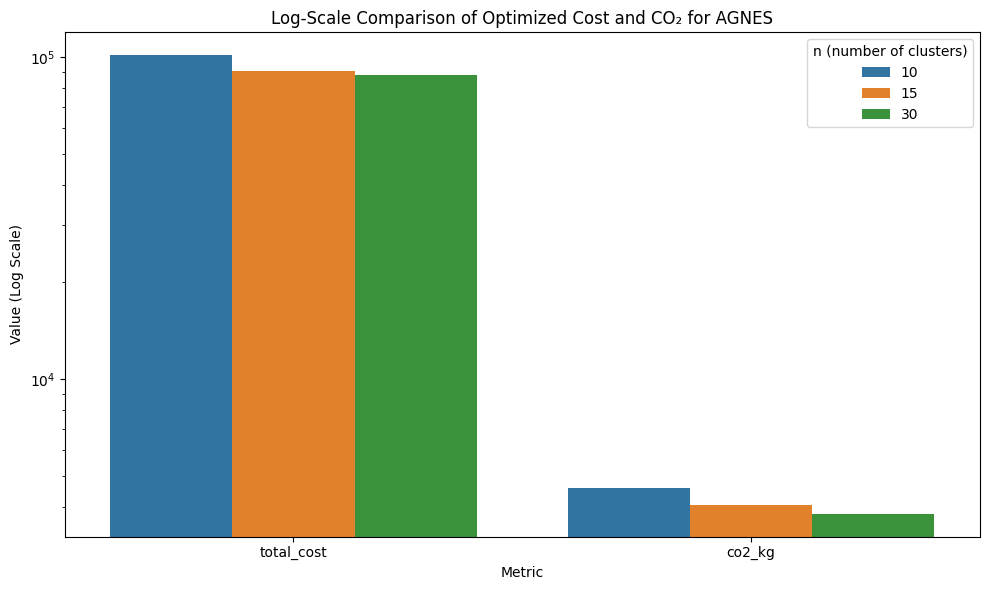

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

summary_df = pd.DataFrame({
    "n": [10, 15, 30],
    "total_cost": [101259, 90712, 87799],
    "co2_kg": [4596.63, 4047.41, 3817.89]
})

df_long = pd.melt(summary_df, id_vars="n",
                  value_vars=["total_cost", "co2_kg"],
                  var_name="Metric", value_name="Value")

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(data=df_long, x="Metric", y="Value", hue="n", palette="tab10")
plt.yscale("log")
plt.ylabel("Value (Log Scale)")
plt.title("Log-Scale Comparison of Optimized Cost and CO₂ for AGNES")
plt.tight_layout()
plt.legend(title="n (number of clusters)")
plt.show()


# Conclusion

Based on the comparison between KMeans and AGNES clustering methods for values of k/n = 10, 15, 30, it is evident that increasing the number of clusters consistently reduces both total cost and CO₂ emissions. KMeans with k=30 achieved the lowest CO₂ emissions (3,921.70 kg) and the lowest overall cost (€86,899), making it the most efficient configuration in terms of environmental and financial optimization. AGNES with n=30 produced a similar result in terms of emissions (3,817.89 kg) but with a slightly higher cost (€87,799).







